In [1]:
import os
import utils
import json
import torch
from torch import nn


In [24]:
import models
from imp import reload
reload(models)
reload(utils)

from models import VanillaCRF, BiLSTMCRF, TransformerCRF


In [3]:

vocab_file = "data/vocab.json"
train_file = "data/train.bmes"

if not os.path.exists(vocab_file):
    utils.build_vocab(train_file, vocab_file)
vocab, tag2id = json.load(open(vocab_file))

print(tag2id)
# load model
    # raise Exception

    

{'<pad>': 0, 'B': 1, 'E': 2, 'S': 3, 'M': 4}


In [31]:
batch_size = 64
n_epochs = 1

def train(model, train_file, vocab, tag2id, device, ckpts):
    # load train data
    X, Y = utils.load_data(train_file, vocab, tag2id)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)

    loader = utils.BatchManager(X, Y, batch_size)

    for epoch in range(n_epochs):
        for bid in range(loader.steps):
            optimizer.zero_grad()
            x, y, mask = loader.next_batch()
            # loss = torch.zeros(1).to(device)
            # for i in range(len(x)):
            #     x[i] = torch.tensor(x[i]).to(device)
            #     y[i] = torch.tensor(y[i]).to(device)
            #     loss += model.neg_log_likelihood(x[i], y[i]).squeeze()
            # loss.backward(retain_graph=True)

            x, y, mask = [torch.LongTensor(k).to(device) for k in [x,y,mask]]
            loss = model(x, y, mask.bool())
            # loss = loss.mean()

            loss.backward()
            optimizer.step()
            ckpts['trn_loss'].append(loss.item())

            print("epoch %d/%d, step %d/%d, loss=%f" % (epoch, n_epochs, bid, loader.steps,
                   loss.detach().cpu().numpy().squeeze()))
        scheduler.step()
        torch.save(model.state_dict(), 'ckpts/params_%d.pkl' % epoch)
        

In [6]:
from copy import deepcopy


In [32]:
device = torch.device('cpu')
# model = VanillaCRF(vocab, tag2id, device).to(device)
model = BiLSTMCRF(vocab, tag2id, 32, 64, device).to(device)
# model = TransformerCRF(vocab, tag2id, 16, 16, device).to(device)


In [36]:
ckpts = {'trn_loss': []}
train(model, train_file, vocab, tag2id, device, ckpts)


Loading data...
epoch 0/1, step 0/297, loss=0.229092
epoch 0/1, step 1/297, loss=0.210469
epoch 0/1, step 2/297, loss=0.214609
epoch 0/1, step 3/297, loss=0.180904
epoch 0/1, step 4/297, loss=0.185413
epoch 0/1, step 5/297, loss=0.219084
epoch 0/1, step 6/297, loss=0.200651
epoch 0/1, step 7/297, loss=0.214149
epoch 0/1, step 8/297, loss=0.214498
epoch 0/1, step 9/297, loss=0.175496
epoch 0/1, step 10/297, loss=0.198631
epoch 0/1, step 11/297, loss=0.191747
epoch 0/1, step 12/297, loss=0.231017
epoch 0/1, step 13/297, loss=0.198887
epoch 0/1, step 14/297, loss=0.204544
epoch 0/1, step 15/297, loss=0.191051
epoch 0/1, step 16/297, loss=0.195828
epoch 0/1, step 17/297, loss=0.178273
epoch 0/1, step 18/297, loss=0.189045
epoch 0/1, step 19/297, loss=0.176779
epoch 0/1, step 20/297, loss=0.176287
epoch 0/1, step 21/297, loss=0.168231
epoch 0/1, step 22/297, loss=0.179382
epoch 0/1, step 23/297, loss=0.205493
epoch 0/1, step 24/297, loss=0.205726
epoch 0/1, step 25/297, loss=0.179696
epoch 

epoch 0/1, step 213/297, loss=0.152053
epoch 0/1, step 214/297, loss=0.115382
epoch 0/1, step 215/297, loss=0.101536
epoch 0/1, step 216/297, loss=0.133953
epoch 0/1, step 217/297, loss=0.104922
epoch 0/1, step 218/297, loss=0.137354
epoch 0/1, step 219/297, loss=0.143147
epoch 0/1, step 220/297, loss=0.111578
epoch 0/1, step 221/297, loss=0.114855
epoch 0/1, step 222/297, loss=0.135195
epoch 0/1, step 223/297, loss=0.141024
epoch 0/1, step 224/297, loss=0.109083
epoch 0/1, step 225/297, loss=0.108135
epoch 0/1, step 226/297, loss=0.101131
epoch 0/1, step 227/297, loss=0.104073
epoch 0/1, step 228/297, loss=0.121609
epoch 0/1, step 229/297, loss=0.128183
epoch 0/1, step 230/297, loss=0.106215
epoch 0/1, step 231/297, loss=0.137615
epoch 0/1, step 232/297, loss=0.125085
epoch 0/1, step 233/297, loss=0.110492
epoch 0/1, step 234/297, loss=0.124642
epoch 0/1, step 235/297, loss=0.120442
epoch 0/1, step 236/297, loss=0.121807
epoch 0/1, step 237/297, loss=0.118653
epoch 0/1, step 238/297, 

<AxesSubplot:>

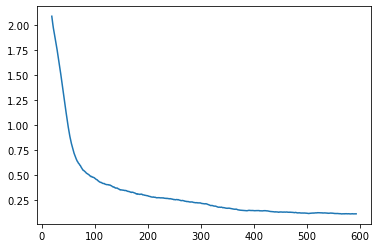

In [37]:
loss1 = [x for x in ckpts['trn_loss'] if x < 30]
import pandas as pd
import seaborn as sns
loss1 = pd.Series(loss1).rolling(window=20).mean()
sns.lineplot(x=range(len(loss1)), y=loss1)


In [40]:
!python main.py --test --model_file ckpts/params_0.pkl


{'<pad>': 0, 'B': 1, 'E': 2, 'S': 3, 'M': 4}
word_embeds.weight torch.Size([4700, 32])
encoder.weight_ih_l0 torch.Size([128, 32])
encoder.weight_hh_l0 torch.Size([128, 32])
encoder.bias_ih_l0 torch.Size([128])
encoder.bias_hh_l0 torch.Size([128])
encoder.weight_ih_l0_reverse torch.Size([128, 32])
encoder.weight_hh_l0_reverse torch.Size([128, 32])
encoder.bias_ih_l0_reverse torch.Size([128])
encoder.bias_hh_l0_reverse torch.Size([128])
hidden2tag.weight torch.Size([5, 64])
hidden2tag.bias torch.Size([5])
crf.transition torch.Size([5, 5])
crf.start_trans torch.Size([5])
crf.end_trans torch.Size([5])
中山大学创办于1924年，是孙中山先生一手创立的
中山 大学 创办 于 192 4年 ， 是 孙 中山 先生 一手 创立 的 


In [39]:
!./scripts/score data/pku_training_words.utf8 data/pku_test_gold.utf8 data/pku_test.out > score.utf8


In [ ]:
## VanillaCRF: P=0.790, R=0.810
"""
## VanillaCRF
=== SUMMARY:
=== TOTAL INSERTIONS:	4570
=== TOTAL DELETIONS:	5613
=== TOTAL SUBSTITUTIONS:	15641
=== TOTAL NCHANGE:	25824
=== TOTAL TRUE WORD COUNT:	104372
=== TOTAL TEST WORD COUNT:	103329
=== TOTAL TRUE WORDS RECALL:	0.796
=== TOTAL TEST WORDS PRECISION:	0.804
=== F MEASURE:	0.800
=== OOV Rate:	0.058
=== OOV Recall Rate:	0.516
=== IV Recall Rate:	0.813

## BiLSTMCRF, epoch 0
=== SUMMARY:
=== TOTAL INSERTIONS:	3693
=== TOTAL DELETIONS:	4422
=== TOTAL SUBSTITUTIONS:	11260
=== TOTAL NCHANGE:	19375
=== TOTAL TRUE WORD COUNT:	104372
=== TOTAL TEST WORD COUNT:	103643
=== TOTAL TRUE WORDS RECALL:	0.850
=== TOTAL TEST WORDS PRECISION:	0.856
=== F MEASURE:	0.853
=== OOV Rate:	0.058
=== OOV Recall Rate:	0.489
=== IV Recall Rate:	0.872


## TransformerCRF

=== SUMMARY:
=== TOTAL INSERTIONS:	4483
=== TOTAL DELETIONS:	6083
=== TOTAL SUBSTITUTIONS:	16349
=== TOTAL NCHANGE:	26915
=== TOTAL TRUE WORD COUNT:	104372
=== TOTAL TEST WORD COUNT:	102772
=== TOTAL TRUE WORDS RECALL:	0.785
=== TOTAL TEST WORDS PRECISION:	0.797
=== F MEASURE:	0.791
=== OOV Rate:	0.058
=== OOV Recall Rate:	0.460
=== IV Recall Rate:	0.805
"""
